# Part 2.0 + 2.1: EDA + Country Clustering 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## Load and Prepare Data

In [2]:
# Load datasets
wb_df = pd.read_csv('./data/worldbank_2017_2021.csv')
regions_df = pd.read_excel('./data/countries_regions.xlsx')
print(f"WorldBank: {wb_df.shape}, Regions: {regions_df.shape}")

WorldBank: (1080, 195), Regions: (217, 3)


In [3]:
wb_df.tail()

,Country Name,Year,Agricultural irrigated land (% of total agricultural land),Agricultural land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)",Arable land (% of land area),Cereal yield (kg per hectare),Crop production index (2014-2016 = 100),Fertilizer consumption (kilograms per hectare of arable land),Food production index (2014-2016 = 100),...,Merchandise exports (current US$),Merchandise imports (current US$),Merchandise trade (% of GDP),"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)",Firms with female participation in ownership (% of firms),Firms with female top manager (% of firms),"Proportion of time spent on unpaid domestic and care work, female (% of 24 hour day)","Proportion of time spent on unpaid domestic and care work, male (% of 24 hour day)","Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care (% of women age 15-49)"
1075,Virgin Islands (U.S.),2021,NaN,9.43,NaN,2.57,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.34,0.21,NaN,NaN,NaN,NaN,NaN
1076,West Bank and Gaza,2021,NaN,64.93,6.32,6.95,2251.9,117.31,371.97,117.39,...,NaN,NaN,NaN,8.55,3.44,NaN,NaN,NaN,NaN,NaN
1077,"Yemen, Rep.",2021,NaN,44.42,NaN,2.19,1524.8,124.71,10.63,120.77,...,6.620000e+08,5.054000e+09,29.68,37.64,9.04,NaN,NaN,NaN,NaN,NaN
1078,Zambia,2021,NaN,32.07,3.00,5.11,2525.0,136.31,63.90,127.49,...,1.010100e+10,6.435000e+09,74.84,4.87,2.36,NaN,NaN,NaN,NaN,NaN
1079,Zimbabwe,2021,NaN,41.88,8.85,10.34,1545.3,129.97,25.98,120.52,...,6.036000e+09,7.577000e+09,47.98,0.12,0.11,NaN,NaN,NaN,NaN,NaN


In [4]:
regions_df.tail()

,CountryName,Region,ThirdWorld
212,Virgin Islands (U.S.),North America,No
213,West Bank and Gaza,Middle East,No
214,"Yemen, Rep.",Middle East,Yes
215,Zambia,Africa,Yes
216,Zimbabwe,Africa,No


In [5]:
# Rename country names to match between datasets
name_map = {
    'United States': 'United States of America',
    'Viet Nam': 'Vietnam',
}

wb_df['Country Name'] = wb_df['Country Name'].replace(name_map)


In [6]:
# Calculate missing percentage
missing_pct = (wb_df.isnull().mean() * 100)
missing_pct[missing_pct > 50].sort_values(ascending=False)


Land area where elevation is below 5 meters (% of total land area)                      100.000000
Population living in areas where elevation is below 5 meters (% of total population)    100.000000
Energy use (kg of oil equivalent per capita)                                            100.000000
Energy imports, net (% of energy use)                                                   100.000000
Children in employment, female (% of female children ages 7-14)                         100.000000
                                                                                           ...    
Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)                      64.722222
Persistence to last grade of primary, male (% of cohort)                                 60.000000
Persistence to last grade of primary, female (% of cohort)                               60.000000
Trained teachers in primary education (% of total teachers)                              58.055556
Short-term

In [7]:
# Has any country name missing?
wb_df["Country Name"].isnull().mean()

np.float64(0.0)

In [8]:
# Drop missing value that exceed 50%
wb_df_proc = wb_df.copy()
th = 0.5 * len(wb_df_proc)

wb_df_proc.dropna(thresh=th, inplace=True, axis = 1)
wb_df_proc.shape


(1080, 119)

In [9]:
# define numerical and categorical columns
num_cols = wb_df_proc.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = regions_df.columns.tolist()
num_cols.remove("Year")
cat_cols.remove("CountryName")

In [10]:
# Impute missing values with median and clip outliers
for col in num_cols:
    med = wb_df_proc[col].median()
    wb_df_proc[col] = wb_df_proc[col].fillna(med)
    wb_df_proc[col] = wb_df_proc[col].fillna(med)

    lower = wb_df_proc[col].quantile(0.05)
    upper = wb_df_proc[col].quantile(0.95)
    wb_df_proc[col] = wb_df_proc[col].clip(lower, upper)
    wb_df_proc[col] = wb_df_proc[col].clip(lower, upper)

In [11]:
# Confirm missing values are gone
missing_pct = (wb_df_proc.isnull().mean() * 100).sort_values(ascending=False)
missing_pct

Country Name                                                                           0.0
Year                                                                                   0.0
Agricultural land (% of land area)                                                     0.0
Agriculture, forestry, and fishing, value added (% of GDP)                             0.0
Arable land (% of land area)                                                           0.0
                                                                                      ... 
Merchandise exports (current US$)                                                      0.0
Merchandise imports (current US$)                                                      0.0
Merchandise trade (% of GDP)                                                           0.0
Contributing family workers, female (% of female employment) (modeled ILO estimate)    0.0
Contributing family workers, male (% of male employment) (modeled ILO estimate)        0.0

In [12]:
# recheck for regions_df
missing_pct = (regions_df.isnull().mean() * 100).sort_values(ascending=False)
missing_pct

CountryName    0.0
Region         0.0
ThirdWorld     0.0
dtype: float64

In [13]:
feature_col = 'GNI per capita, PPP (current international $)'

# average by country (2017-2021)
country_avg = wb_df_proc.groupby('Country Name').mean().reset_index()

combined_df = country_avg.merge(regions_df, left_on='Country Name', right_on='CountryName', how='inner')

# Drop missing and prepare for clustering
clustering_df = combined_df.dropna(subset=[feature_col]).copy()
print(f"Countries for clustering: {len(clustering_df)}")

# Scale feature
scaler = StandardScaler()
X = clustering_df[[feature_col]].values
X_scaled = scaler.fit_transform(X)



Countries for clustering: 216


## Check normality and correlation

### Highly Correlation test

In [14]:
threshold = 0.9
corr_matrix = combined_df[num_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
len(to_drop)

19

### Normality test

In [15]:
from scipy.stats import normaltest

def check_normality(df,alpha=0.05):

    stat, p_value = normaltest(df)
    
    if p_value > alpha:
        return 'Yes'
    else:
        return 'No'

results = []
for col in num_cols:
    result = check_normality(combined_df[col])
    results.append({'Column': col, 'Normal (α=0.05)': result})

summary_df = pd.DataFrame(results)
print(f"\nTotal columns tested: {len(summary_df)}")

normal_count = (summary_df['Normal (α=0.05)'] == 'Yes').sum()
not_normal_count = (summary_df['Normal (α=0.05)'] == 'No').sum()

print(f"  - Normally distributed:     {normal_count}")
print(f"  - NOT normally distributed: {not_normal_count}")


display(summary_df)


Total columns tested: 117
  - Normally distributed:     13
  - NOT normally distributed: 104


,Column,Normal (α=0.05)
0,Agricultural land (% of land area),No
1,"Agriculture, forestry, and fishing, value adde...",No
2,Arable land (% of land area),No
3,Cereal yield (kg per hectare),No
4,Crop production index (2014-2016 = 100),Yes
...,...,...
112,Merchandise exports (current US$),No
113,Merchandise imports (current US$),No
114,Merchandise trade (% of GDP),No
115,"Contributing family workers, female (% of fema...",No


## Perform country clustering with K-Means

### Define evaluation function

In [ ]:
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)

    # Compute cluster centroids
    centroids = np.array([
        X[labels == k].mean(axis=0) for k in unique_clusters
    ])
    
    from scipy.spatial.distance import cdist
    # Inter-cluster distance (minimum distance between clusters)
    inter_cluster_dist = np.min(
        cdist(centroids, centroids)[np.triu_indices(len(unique_clusters), k=1)]
    )

    # Intra-cluster distance (maximum cluster diameter)
    intra_cluster_dist = max(
        np.max(cdist(X[labels == k], X[labels == k]))
        for k in unique_clusters
    )
    return inter_cluster_dist / intra_cluster_dist

def evaluate_clustering(X, X_clusters):
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    silhouette = silhouette_score(X, X_clusters)
    db = davies_bouldin_score(X, X_clusters)
    dunn = dunn_index(X, X_clusters)
    ch = calinski_harabasz_score(X, X_clusters)
    return silhouette, db, dunn, ch

### Find the number of cluster

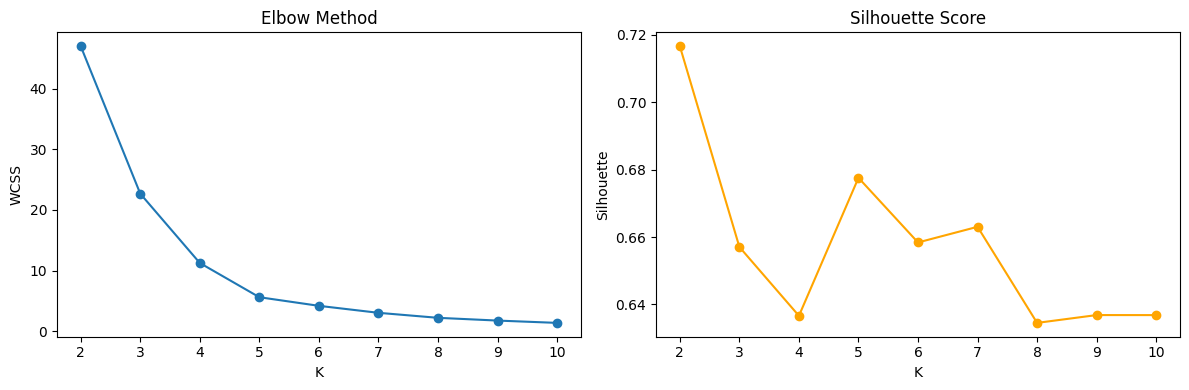

In [38]:
# Elbow and Silhouette for K selection
wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=23)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(k_range, wcss, marker='o')
axes[0].set_xlabel('K'); axes[0].set_ylabel('WCSS'); axes[0].set_title('Elbow Method')
axes[1].plot(k_range, silhouette_scores, marker='o', color='orange')
axes[1].set_xlabel('K'); axes[1].set_ylabel('Silhouette'); axes[1].set_title('Silhouette Score')
plt.tight_layout()
plt.show()



### Modeling using k = 5

In [46]:
# choosing base on elbow method and silhouette score
best_k = 5
# Apply K-Means
kmeans_model = KMeans(n_clusters=best_k, n_init=10, random_state=23)
kmeans_labels = kmeans_model.fit_predict(X_scaled)
clustering_df['KMeans_Cluster'] = kmeans_labels

# Evaluate K-Means
silhouette, db, dunn, ch = evaluate_clustering(X_scaled, kmeans_labels)

print('Silhouette Index: ', silhouette)
print('Davies-Bouldin Index: ', db)
print('Dunn Index: ', dunn)
print('CH Index: ', ch)




Silhouette Index:  0.6775380868868375
Davies-Bouldin Index:  0.407516079936867
Dunn Index:  0.6895119777501192
CH Index:  1987.158663928231


## Visualization and Analysis

### Define ploting function

In [40]:
# Define helper functions for visualization
def create_radar_graph(X, X_clusters):
    clustered_df = X.copy()
    clustered_df["Cluster"] = X_clusters
    cluster_means = clustered_df.groupby("Cluster").mean()
    
    # plot Radar Chart for cluster means
    labels = cluster_means.columns
    num_features = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1]
    
    plt.figure(figsize=(8, 8))
    
    for i, row in cluster_means.iterrows():
        values = row.tolist()
        values += values[:1]
        plt.polar(angles, values, label=f"Cluster {i}")
    
    plt.xticks(angles[:-1], labels, fontsize=8)
    plt.title("Cluster Profiles (Feature Means)")
    plt.legend()
    plt.show()

def create_feature_boxplots(X, X_clusters):
    clustered_df = X.copy()
    clustered_df["Cluster"] = X_clusters

    # plot boxplots of feature values 
    for col in X.columns:
        clustered_df.boxplot(column=col, by="Cluster", figsize=(6, 4))
        plt.title(f"{col} by Cluster")
        plt.suptitle("")
        plt.show()

def create_pca_scatterplot(X_scaled, X_clusters):
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(7, 5))
    unique_clusters = np.unique(X_clusters)
    for cluster_id in unique_clusters:
        idx = X_clusters == cluster_id
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=40, label=f"Cluster {cluster_id}")
    
    plt.title("PCA 2D Scatterplot of Clusters")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(title="Cluster ID")
    plt.show()

### plot to compare each cluster with feature value

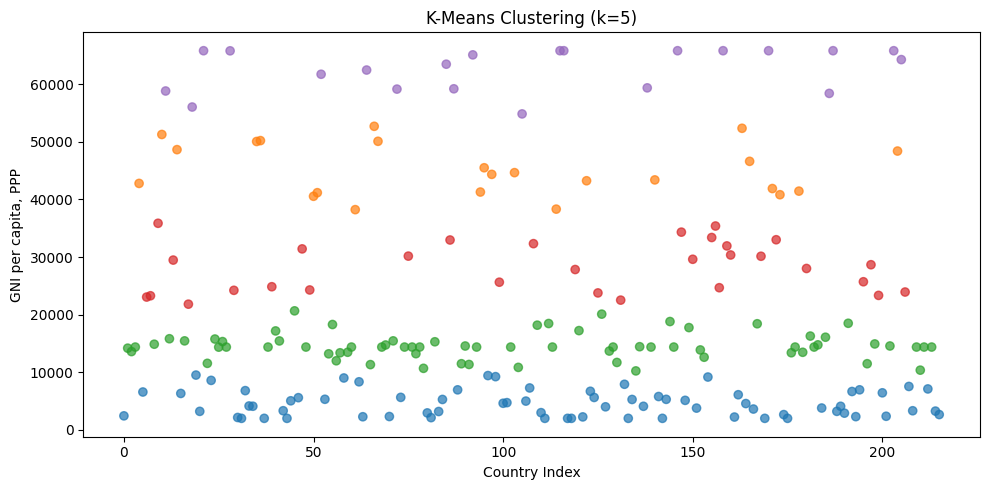

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))

# K-Means
colors_km = plt.cm.tab10(clustering_df['KMeans_Cluster'])
ax.scatter(range(len(clustering_df)), clustering_df[feature_col], c=colors_km, alpha=0.7)
ax.set_title(f'K-Means Clustering (k={best_k})')
ax.set_xlabel('Country Index')
ax.set_ylabel('GNI per capita, PPP')
plt.tight_layout()
plt.show()

### Using RandomForest for find top 10 column best describe of clustering

=== Top 10 Features (Random Forest Importance) ===


,Feature,Importance
1,"Agriculture, forestry, and fishing, value adde...",0.043363
54,Population ages 0-14 (% of total population),0.038856
68,Fixed broadband subscriptions (per 100 people),0.034447
17,"Mortality rate, under-5 (per 1,000 live births)",0.029972
69,Fixed telephone subscriptions (per 100 people),0.027382
89,Prevalence of anemia among children (% of chil...,0.025277
82,"Life expectancy at birth, total (years)",0.024946
44,Price level ratio of PPP conversion factor (GD...,0.024126
80,"Life expectancy at birth, female (years)",0.022519
15,Access to electricity (% of population),0.021928


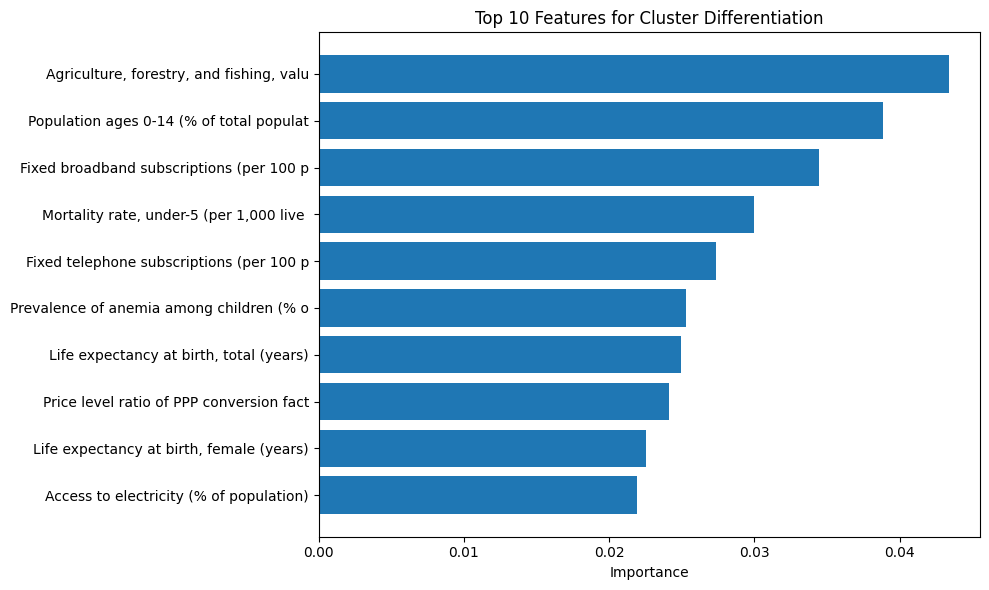

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data - exclude feature_col from features
feature_list = [c for c in num_cols if c != feature_col]  # <-- Fixed
X_features = clustering_df[feature_list].copy()
y_clusters = clustering_df['KMeans_Cluster'].values

# Train Random Forest to predict cluster
rf = RandomForestClassifier(n_estimators=100, random_state=23)
rf.fit(X_features, y_clusters)

# Get feature importance (use feature_list, not num_cols)
feature_importance = pd.DataFrame({
    'Feature': feature_list,  # <-- Fixed
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 10 features
top_10_features = feature_importance.head(10)['Feature'].tolist()

print("=== Top 10 Features (Random Forest Importance) ===")
display(feature_importance.head(10))

# Plot importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(10)['Feature'].str[:40], feature_importance.head(10)['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Features for Cluster Differentiation')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Radar plot

Top 10 distinctive features:
  1. Agriculture, forestry, and fishing, value added (% of GDP)
  2. Population ages 0-14 (% of total population)
  3. Fixed broadband subscriptions (per 100 people)
  4. Mortality rate, under-5 (per 1,000 live births)
  5. Fixed telephone subscriptions (per 100 people)
  6. Prevalence of anemia among children (% of children ages 6-59
  7. Life expectancy at birth, total (years)
  8. Price level ratio of PPP conversion factor (GDP) to market e
  9. Life expectancy at birth, female (years)
  10. Access to electricity (% of population)


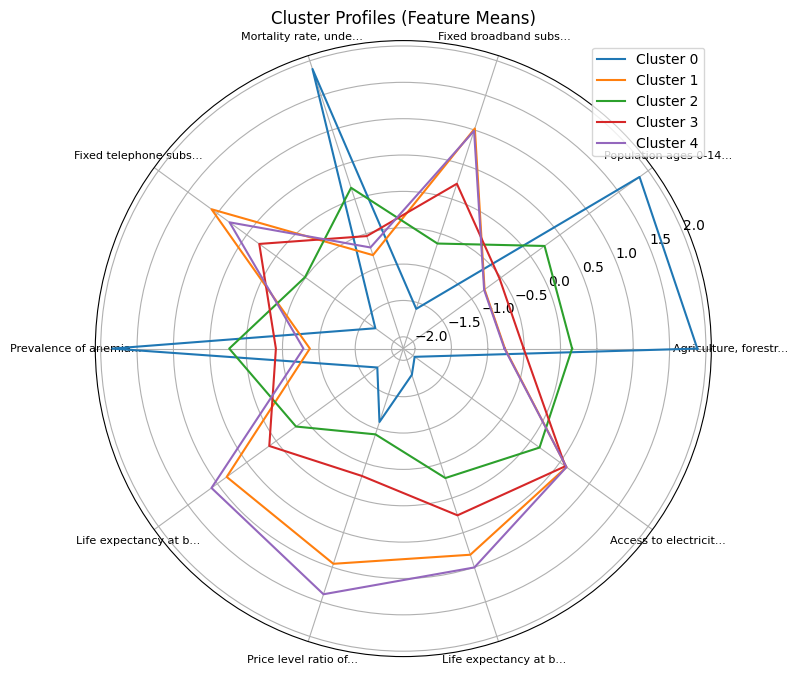

In [43]:
# Get cluster means for top 10 features
cluster_means = clustering_df.groupby('KMeans_Cluster')[top_10_features].mean()

print("Top 10 distinctive features:")
for i, f in enumerate(top_10_features, 1):
    print(f"  {i}. {f[:60]}")

# Scale the cluster means
scaler = StandardScaler()
X_top10_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Rename columns to be more readable
X_top10_scaled.columns = [c[:20] + '...' if len(c) > 20 else c for c in X_top10_scaled.columns]

# Pass cluster index (0, 1, 2, ...) for radar - NOT individual country labels
create_radar_graph(X_top10_scaled, X_top10_scaled.index.values)

### Top 2 PCs plot

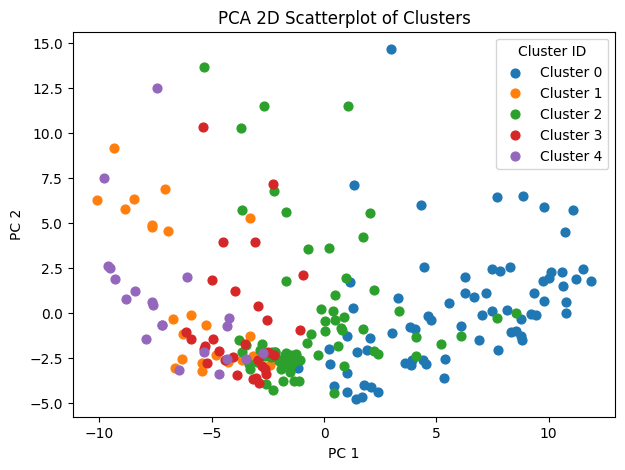

In [44]:
X_multi = clustering_df[num_cols].values
scaler_multi = StandardScaler()
X_multi_scaled = scaler_multi.fit_transform(X_multi)
create_pca_scatterplot(X_multi_scaled, clustering_df['KMeans_Cluster'].values)

### Box plot of top 5 column

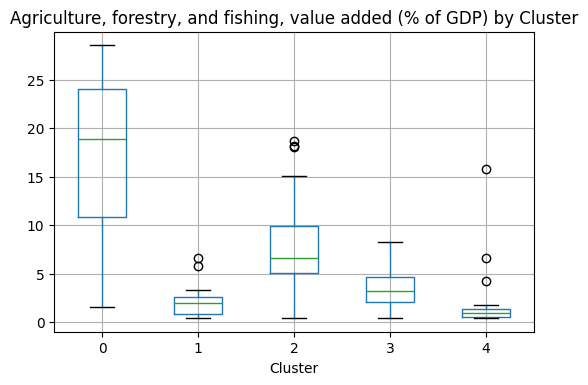

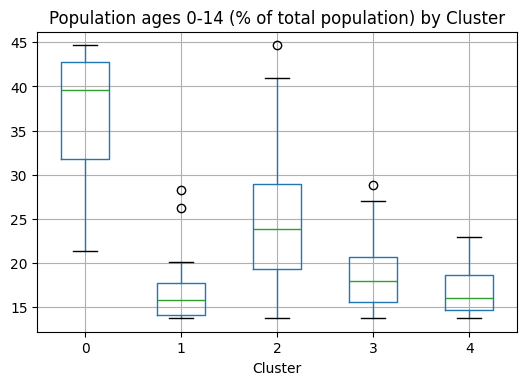

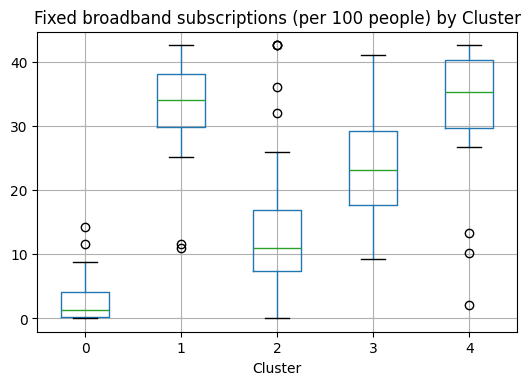

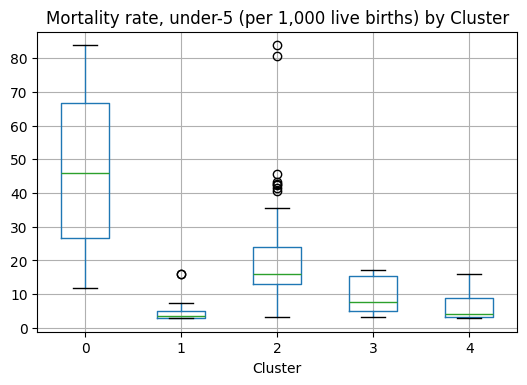

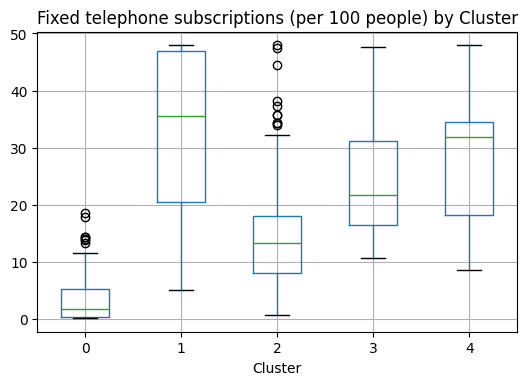

In [45]:
X_top5 = clustering_df[top_10_features[:5]].copy()
create_feature_boxplots(X_top5, clustering_df['KMeans_Cluster'].values)